# Inputs

In [1]:
import os
import re

folder_name = '327/Pulse Calibration Redo'
file_names = [file_name for file_name in os.listdir(folder_name) if re.match(r'^\d+_\d+\.csv$', file_name)]

# Import packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
import scipy.optimize as opt
from scipy.stats import t
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
# %matplotlib widget

In [3]:
# Fit a decaying exponential to the envelope (no need for peak detection here)
# Model: A * exp(-t / T2star*) + C
def model_exp(t, A, T2star, C):
    return A * np.exp(-t / T2star) + C

# Load data

In [4]:
# Read the data and pulse times from filenames
data = []
pulse_times = []
for file_name in file_names:
    # Assumes the file name format has the pulse time (in us) before 'us'
    pulse_time = int(file_name.split('/')[-1].split('_')[0])
    df = pd.read_csv(os.path.join(folder_name, file_name), header=None, names=['t', 'CH1', 'CH2'])
    df = df.dropna()
    df = df[(df['t'] > 0.001) & (df['t'] < 0.004)]
    # df = df[(df['t'] > 0.001)]
    data.append(df)
    pulse_times.append(pulse_time)

# Use sum of squares to reconstruct envelope, and fit envelope

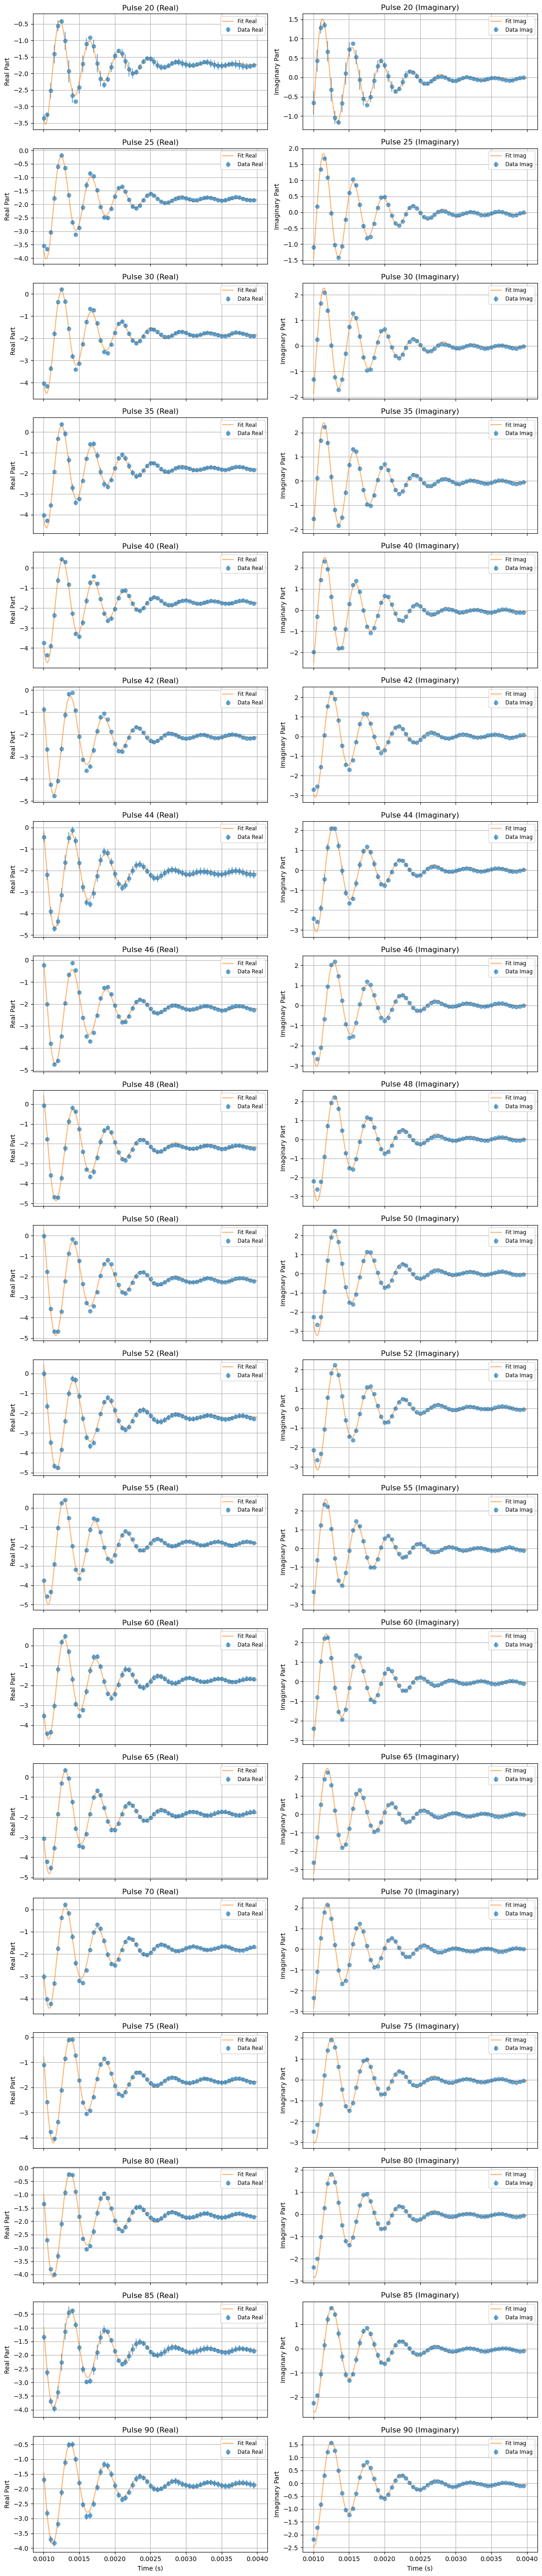

Global T2star: 0.6465 ± 0.0002 ms


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import curve_fit
from scipy.signal import butter, filtfilt

# Define the complex exponential model with frequency.
def model_complex(t, A, T2star, f, phi, C_real, C_imag):
    """
    Returns the complex signal:
      A * exp(-t/T2star) * exp(i*(2*pi*f*t + phi)) + (C_real + i*C_imag)
    """
    return A * np.exp(-t / T2star) * np.exp(1j * (2 * np.pi * f * t + phi)) + (C_real + 1j * C_imag)

# Group the data by pulse time.
grouped_data = defaultdict(list)
for df, pulse_time in zip(data, pulse_times):
    grouped_data[pulse_time].append(df)

# Process each group to compute the averaged (complex) signal and its standard deviation.
group_data_list = []
# Sort the groups by pulse time so the order is fixed.
pulse_times_sorted = sorted(grouped_data.keys())
for pulse_time in pulse_times_sorted:
    dfs = grouped_data[pulse_time]
    signals = []   # will store the complex signal for each trace in this group
    t_common = None
    for df in dfs:
        t = df['t'].values
        if t_common is None:
            t_common = t  # assume all traces in the group share the same time array
        # Create the complex signal (using CH1 as real and CH2 as imaginary).
        signal = df['CH1'].values + 1j * df['CH2'].values
        # Smooth the signal using a lowpass Butterworth filter.
        b, a = butter(3, 5000, btype="lowpass", fs=500000)
        signal = filtfilt(b, a, signal)
        signals.append(signal)
    signals = np.array(signals)
    # Compute the average and standard deviation (separately for real and imag).
    avg_real = np.mean(np.real(signals), axis=0)
    avg_imag = np.mean(np.imag(signals), axis=0)
    std_real = np.std(np.real(signals), axis=0, ddof=1) if signals.shape[0] > 1 else np.zeros_like(avg_real)
    std_imag = np.std(np.imag(signals), axis=0, ddof=1) if signals.shape[0] > 1 else np.zeros_like(avg_imag)
    avg_signal = avg_real + 1j * avg_imag
    group_data_list.append({
       'pulse_time': pulse_time,
       't': t_common,
       'avg_signal': avg_signal,
       'std_real': std_real,
       'std_imag': std_imag
    })

# Construct the composite ydata vector for simultaneous fitting.
# For each group, we stack the averaged real and imaginary parts.
ydata_list = []
for group in group_data_list:
    y_group = np.concatenate((group['avg_signal'].real, group['avg_signal'].imag))
    ydata_list.append(y_group)
ydata_sim = np.concatenate(ydata_list)

# We'll use the list of time arrays (one per group) in the simultaneous model.
# This is a global list used by the model function.
group_t_list = [group['t'] for group in group_data_list]

# Define the composite model function.
# The parameter vector is organized as follows:
#   For each group i (of N groups): [A_i, f_i, phi_i, C_real_i, C_imag_i]
#   Followed by one global parameter: T2star
# So the total number of parameters is 5*N + 1.
def model_simultaneous(dummy_x, *params):
    N = len(group_t_list)
    T2star = params[-1]
    y_model = []
    for i in range(N):
        A    = params[5*i + 0]
        f    = params[5*i + 1]
        phi  = params[5*i + 2]
        C_re = params[5*i + 3]
        C_im = params[5*i + 4]
        t_arr = group_t_list[i]
        model_vals = model_complex(t_arr, A, T2star, f, phi, C_re, C_im)
        # Stack real and imaginary parts as done in the individual fits.
        y_model.append(np.concatenate((model_vals.real, model_vals.imag)))
    return np.concatenate(y_model)

# Build an initial guess (p0) for the parameters.
# For each group, we guess:
#   A: 10 (or you could use np.abs(avg_signal[0]) if preferred)
#   f: 2000 Hz,
#   phi: phase of the first point of the averaged signal,
#   C_real: 0, and C_imag: 0.
# Then append one global guess for T2star (e.g., 0.001 s).
p0 = []
for group in group_data_list:
    avg_signal = group['avg_signal']
    p0.extend([15, -2200, np.angle(avg_signal[0]), -2, 0])
p0.append(0.0007)

# Perform the simultaneous fit.
# We pass a dummy xdata (None) since our model function uses the global group_t_list.
try:
    # Use the standard deviations of the real and imaginary parts as weights.
    popt, pcov = curve_fit(model_simultaneous, None, ydata_sim, p0=p0,
                           sigma=np.concatenate([group['std_real'] for group in group_data_list] +
                                               [group['std_imag'] for group in group_data_list]),
                           absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    fit_success = True
except RuntimeError:
    popt = [np.nan] * (len(p0))
    perr = [np.nan] * (len(p0))
    fit_success = False

# Build a list of fit results for each group (for later plotting).
all_fits = []
N = len(group_t_list)
global_T2star = popt[-1]
for i, group in enumerate(group_data_list):
    # Extract the parameters for group i.
    A    = popt[5*i + 0]
    f    = popt[5*i + 1]
    phi  = popt[5*i + 2]
    C_re = popt[5*i + 3]
    C_im = popt[5*i + 4]
    t_arr = group['t']
    fitted_curve = model_complex(t_arr, A, global_T2star, f, phi, C_re, C_im)
    all_fits.append({
        'pulse_time': group['pulse_time'],
        't': t_arr,
        'avg_real': np.real(group['avg_signal']),
        'avg_imag': np.imag(group['avg_signal']),
        'std_real': group['std_real'],
        'std_imag': group['std_imag'],
        'fit_real': fitted_curve.real,
        'fit_imag': fitted_curve.imag,
        # For convenience we store each group’s parameters along with the shared T2star.
        'popt': popt[5*i:5*i+5] + [global_T2star],
        'perr': perr[5*i:5*i+5].tolist() + [perr[-1]],
        'fit_success': fit_success
    })

# Plot the fits versus the averaged data (with error bars) for each pulse time.
num_fits = len(all_fits)
fig, axs = plt.subplots(nrows=num_fits, ncols=2, figsize=(12, 3*num_fits), sharex=True)
if num_fits == 1:
    axs = np.array([axs])
for i, fit in enumerate(all_fits):
    DOWNSAMPLE_RATE = 25
    # Real part subplot.
    axs[i, 0].errorbar(fit['t'][::DOWNSAMPLE_RATE], fit['avg_real'][::DOWNSAMPLE_RATE],
                        yerr=fit['std_real'][::DOWNSAMPLE_RATE], fmt='o', alpha=0.6, label='Data Real')
    if fit['fit_success']:
        axs[i, 0].plot(fit['t'], fit['fit_real'], '-', alpha=0.6, label='Fit Real')
    else:
        axs[i, 0].text(0.05, 0.9, 'Fit Failed', transform=axs[i, 0].transAxes, color='red')
    axs[i, 0].set_ylabel('Real Part')
    axs[i, 0].set_title(f'Pulse {fit["pulse_time"]} (Real)')
    axs[i, 0].legend(fontsize='small')
    axs[i, 0].grid(True)
    
    # Imaginary part subplot.
    axs[i, 1].errorbar(fit['t'][::DOWNSAMPLE_RATE], fit['avg_imag'][::DOWNSAMPLE_RATE],
                        yerr=fit['std_imag'][::DOWNSAMPLE_RATE], fmt='o', alpha=0.6, label='Data Imag')
    if fit['fit_success']:
        axs[i, 1].plot(fit['t'], fit['fit_imag'], '-', alpha=0.6, label='Fit Imag')
    else:
        axs[i, 1].text(0.05, 0.9, 'Fit Failed', transform=axs[i, 1].transAxes, color='red')
    axs[i, 1].set_ylabel('Imaginary Part')
    axs[i, 1].set_title(f'Pulse {fit["pulse_time"]} (Imaginary)')
    axs[i, 1].legend(fontsize='small')
    axs[i, 1].grid(True)

# Label x-axis on the bottom row.
for ax in axs[-1, :]:
    ax.set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

# Build a summary DataFrame for the amplitude A from each pulse time group.
results_list = []
for fit in all_fits:
    if fit['fit_success']:
        A = np.abs(fit['popt'][0])
        A_err = fit['perr'][0]
        results_list.append({'Pulse Time (us)': fit['pulse_time'], 'A': A, 'A_err': A_err})
results_df = pd.DataFrame(results_list).sort_values('Pulse Time (us)')

# Print global T2star and its uncertainty.
if fit_success:
    print(f"Global T2star: {global_T2star*1e3:.4f} ± {perr[-1]*1e3:.4f} ms")

In [18]:
# Print all the fitted parameters
for i, fit in enumerate(all_fits):
    if fit['fit_success']:
        print(f"Pulse Time {fit['pulse_time']} us: A={fit['popt'][0]:.4f} ± {fit['perr'][0]:.4f}, "
                f"f={fit['popt'][1]:.4f} ± {fit['perr'][1]:.4f}, "
                f"phi={fit['popt'][2]:.4f} ± {fit['perr'][2]:.4f}, "
                f"C_real={fit['popt'][3]:.4f} ± {fit['perr'][3]:.4f}, "
                f"C_imag={fit['popt'][4]:.4f} ± {fit['perr'][4]:.4f}, "
                f"T2star={fit['popt'][-1]*1e3:.4f} ± {fit['perr'][-1]*1e3:.4f} ms")
    else:
        print("Fit failed for some groups.")

Pulse Time 20 us: A=8.9094 ± 0.0255, f=-2419.6701 ± 1.4452, phi=-0.0344 ± 0.0125, C_real=-1.7195 ± 0.0023, C_imag=-0.0408 ± 0.0015, T2star=-40.7666 ± 0.0002 ms
Pulse Time 25 us: A=11.0818 ± 0.0304, f=-2389.4093 ± 1.4153, phi=-0.0191 ± 0.0120, C_real=-1.8104 ± 0.0019, C_imag=-0.0410 ± 0.0022, T2star=-41.0495 ± 0.0002 ms
Pulse Time 30 us: A=13.4798 ± 0.0197, f=-2387.2258 ± 0.6553, phi=0.0230 ± 0.0065, C_real=-1.8043 ± 0.0016, C_imag=-0.0163 ± 0.0011, T2star=-16.3174 ± 0.0002 ms
Pulse Time 35 us: A=14.4764 ± 0.0401, f=-2359.2318 ± 1.0809, phi=-0.1843 ± 0.0092, C_real=-1.7579 ± 0.0048, C_imag=-0.0361 ± 0.0018, T2star=-36.1357 ± 0.0002 ms
Pulse Time 40 us: A=15.3310 ± 0.0293, f=-2325.6387 ± 0.7316, phi=-0.2257 ± 0.0066, C_real=-1.7308 ± 0.0024, C_imag=-0.0473 ± 0.0011, T2star=-47.2671 ± 0.0002 ms
Pulse Time 42 us: A=-15.3340 ± 0.0263, f=-2144.3646 ± 1.1000, phi=-3.3544 ± 0.0099, C_real=-2.0924 ± 0.0032, C_imag=0.0259 ± 0.0016, T2star=25.8636 ± 0.0002 ms
Pulse Time 44 us: A=-15.6468 ± 0.0439

  0%|          | 0/19 [00:00<?, ?it/s]

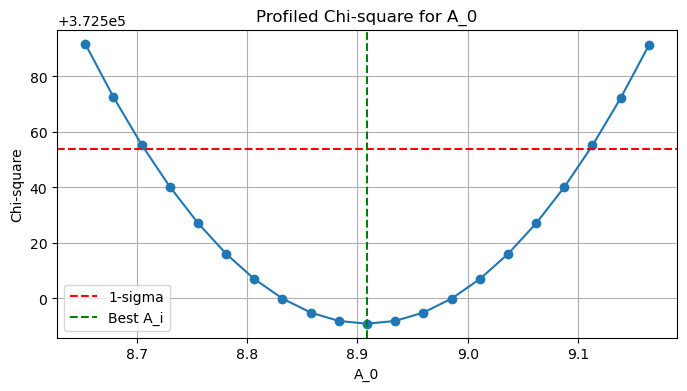

  5%|▌         | 1/19 [00:27<08:23, 27.96s/it]

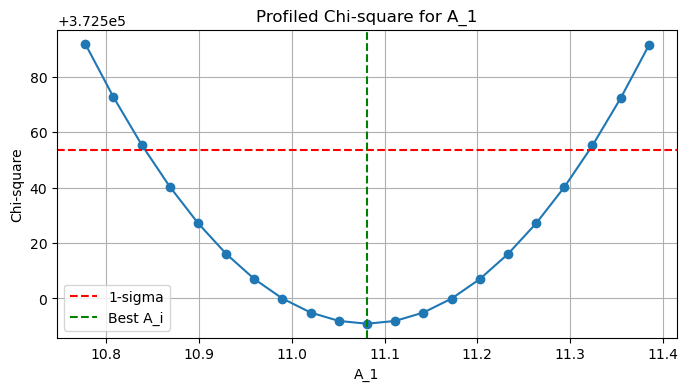

 11%|█         | 2/19 [00:56<08:05, 28.54s/it]

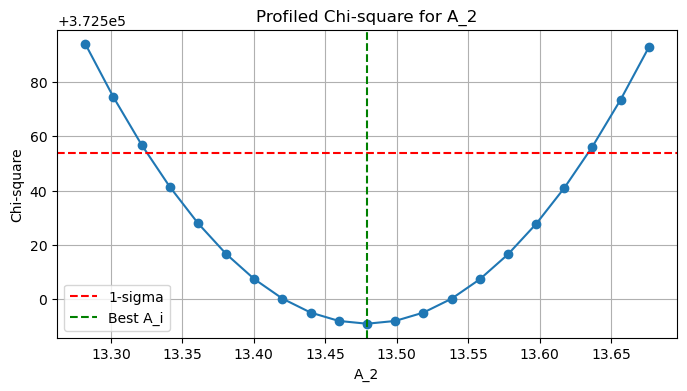

 16%|█▌        | 3/19 [01:26<07:41, 28.87s/it]

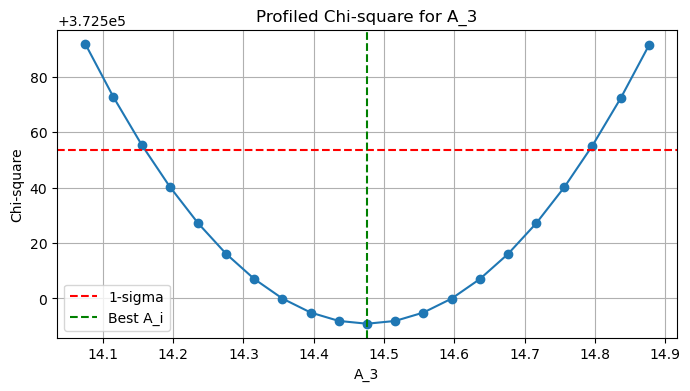

 21%|██        | 4/19 [01:54<07:10, 28.69s/it]

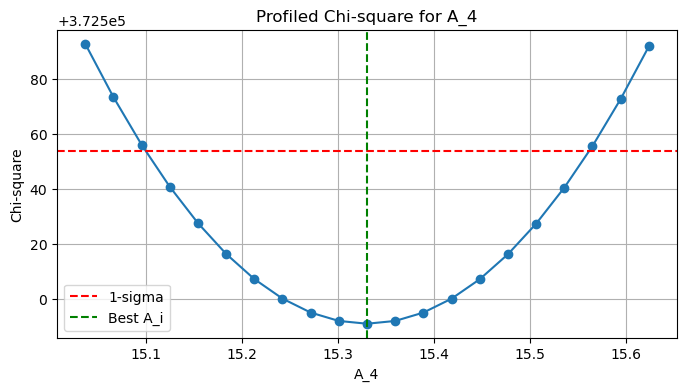

 26%|██▋       | 5/19 [02:23<06:43, 28.84s/it]

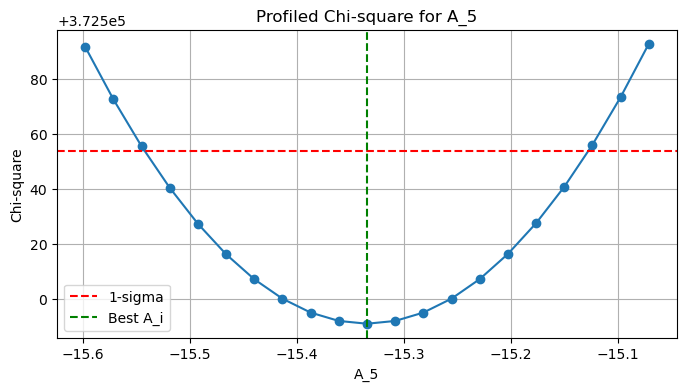

 32%|███▏      | 6/19 [02:55<06:26, 29.74s/it]

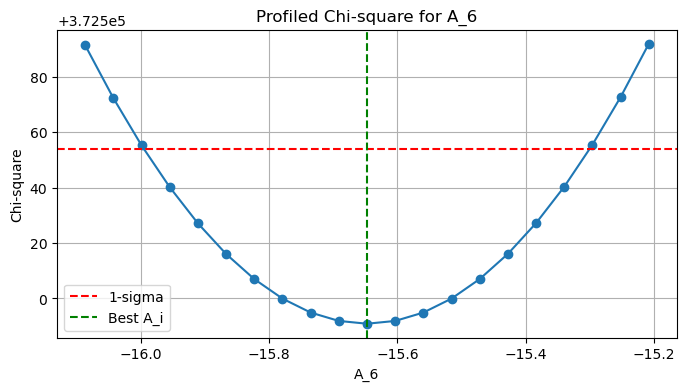

 37%|███▋      | 7/19 [03:22<05:49, 29.09s/it]

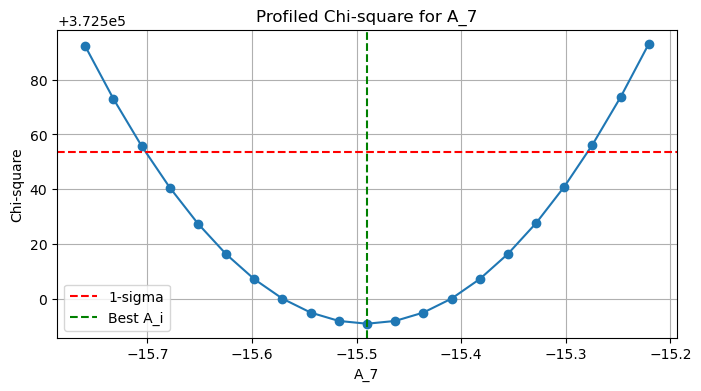

 42%|████▏     | 8/19 [03:51<05:18, 28.99s/it]

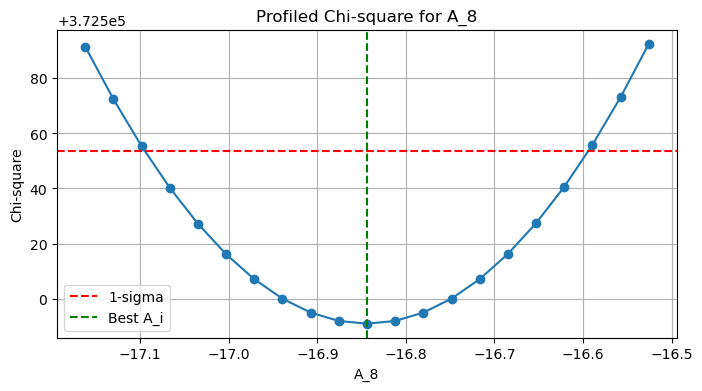

 47%|████▋     | 9/19 [04:20<04:49, 28.96s/it]

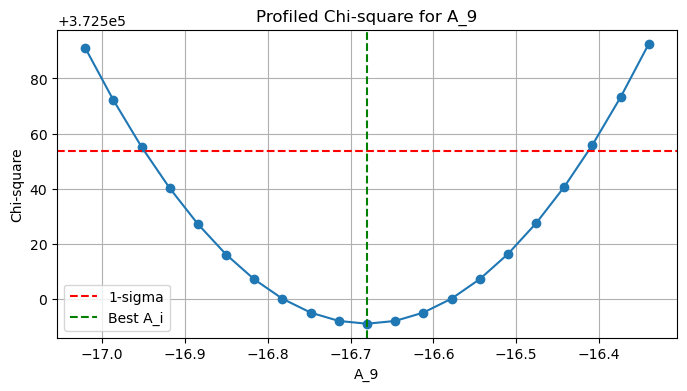

 53%|█████▎    | 10/19 [04:49<04:20, 28.91s/it]

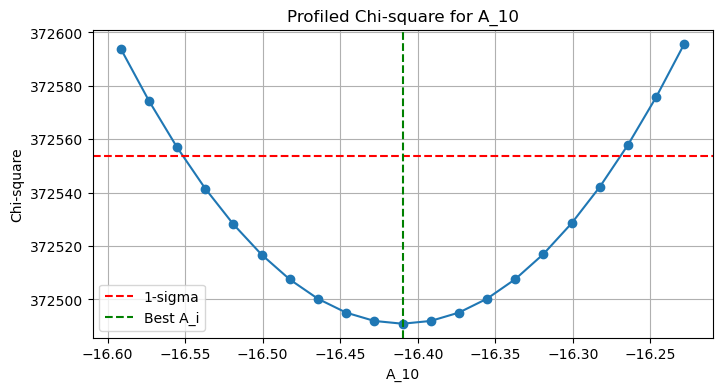

 58%|█████▊    | 11/19 [05:21<03:58, 29.75s/it]

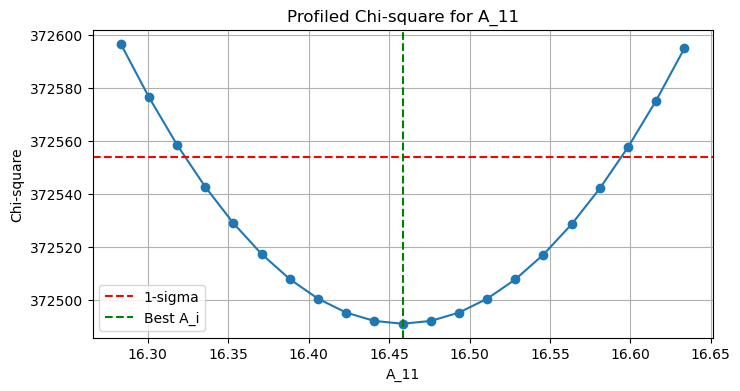

 63%|██████▎   | 12/19 [05:53<03:34, 30.66s/it]

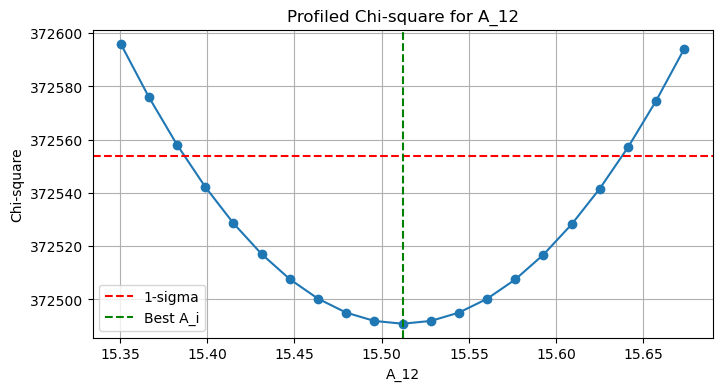

 68%|██████▊   | 13/19 [06:27<03:09, 31.52s/it]

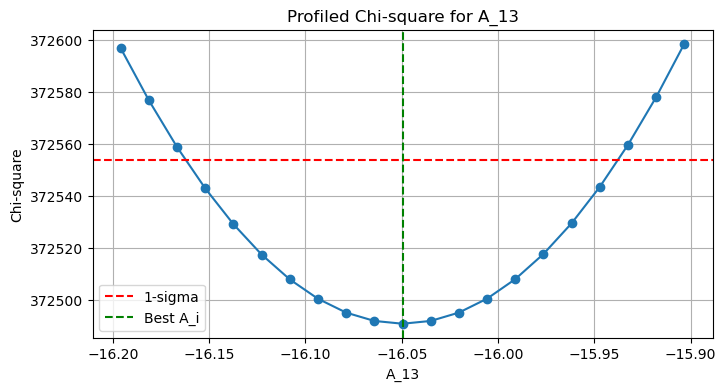

 74%|███████▎  | 14/19 [07:04<02:45, 33.09s/it]

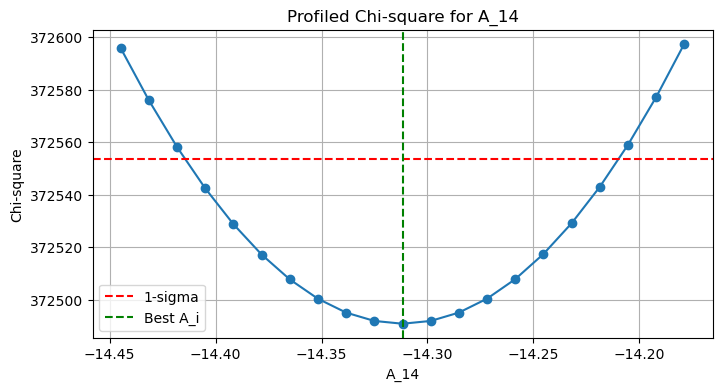

 79%|███████▉  | 15/19 [07:36<02:11, 32.82s/it]

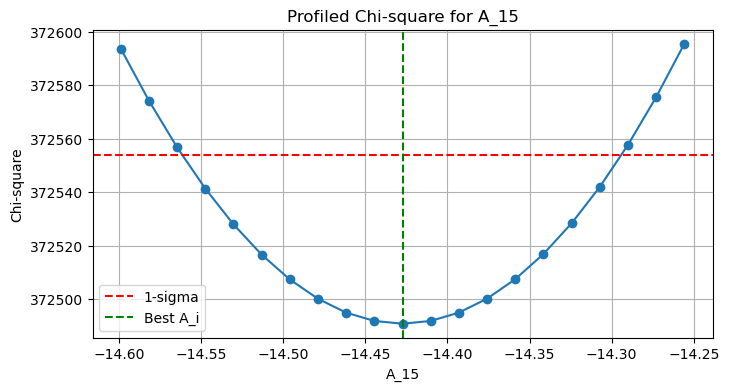

 84%|████████▍ | 16/19 [08:09<01:38, 32.89s/it]

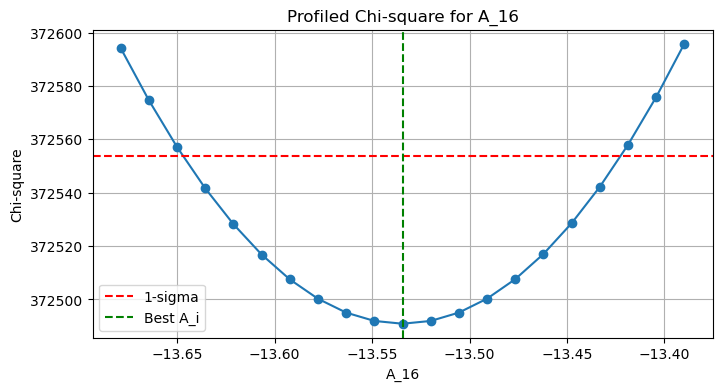

 89%|████████▉ | 17/19 [08:42<01:05, 32.85s/it]

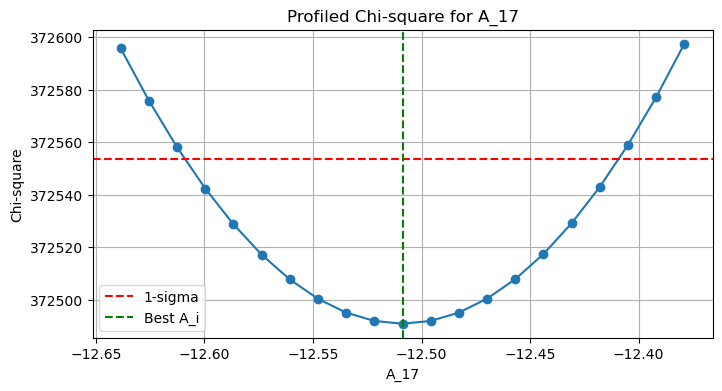

 95%|█████████▍| 18/19 [09:13<00:32, 32.50s/it]

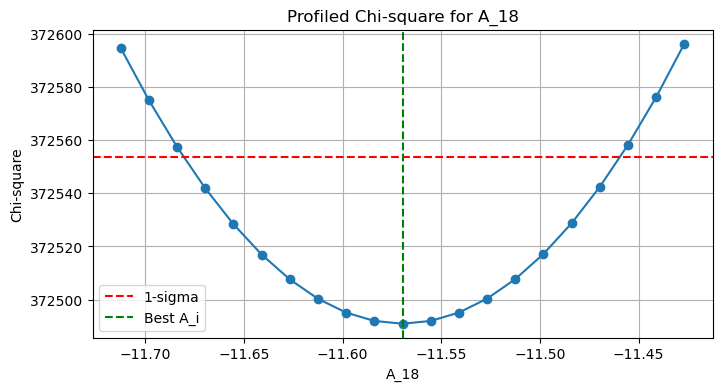

100%|██████████| 19/19 [09:43<00:00, 30.72s/it]

Profiled 1-sigma errors for each A_i:
A_0: best=8.9087, -err=0.20135, +err=0.20181, avg_err=0.20158
A_1: best=11.081, -err=0.23959, +err=0.24018, avg_err=0.23989
A_2: best=13.479, -err=0.1538, +err=0.15459, avg_err=0.1542
A_3: best=14.476, -err=0.31605, +err=0.31687, avg_err=0.31646
A_4: best=15.33, -err=0.23, +err=0.23092, avg_err=0.23046
A_5: best=-15.335, -err=0.20791, +err=0.20695, avg_err=0.20743
A_6: best=-15.647, -err=0.34744, +err=0.34661, avg_err=0.34702
A_7: best=-15.49, -err=0.21195, +err=0.2112, avg_err=0.21158
A_8: best=-16.844, -err=0.25124, +err=0.25018, avg_err=0.25071
A_9: best=-16.68, -err=0.26908, +err=0.26741, avg_err=0.26825
A_10: best=-16.41, -err=0.14162, +err=0.14061, avg_err=0.14112
A_11: best=16.458, -err=0.13503, +err=0.13594, avg_err=0.13549
A_12: best=15.512, -err=0.12479, +err=0.12569, avg_err=0.12524
A_13: best=-16.05, -err=0.11236, +err=0.11165, avg_err=0.112
A_14: best=-14.312, -err=0.10267, +err=0.10202, avg_err=0.10235
A_15: best=-14.427, -err=0.13393

In [19]:
import copy
from scipy.optimize import curve_fit

def compute_chi_square(params, ydata, sigma):
    """
    Computes total chi-square for the simultaneous model,
    given a full parameter vector `params`.  This uses the
    same time arrays (group_t_list) and the same data vector
    (ydata_sim) as your final simultaneous fit.
    
    params: 1D array with length = 5*N + 1  (5 per group, plus global T2star)
    ydata:  1D array of all stacked real+imag data
    sigma:  1D array of all stacked std devs
    """
    # Evaluate the model at these parameters.
    y_model = model_simultaneous(None, *params)
    # Compute chi-square = sum( ((y - y_model)/sigma)^2 ).
    chi_sq = np.sum( ((ydata - y_model)/sigma)**2 )
    return chi_sq

def model_simultaneous_fixed_Ai(dummy_x, *free_params):
    """
    A modified version of model_simultaneous(...) that
    fixes A_i (the amplitude for group i) to a chosen value,
    while the remaining parameters are free to vary.
    
    We'll reconstruct a 'full_params' vector of length 5*N + 1
    from 'free_params' (which is 5*N + 1 - 1 = 5*N for 1 amplitude fixed).
    """
    # 'i_fixed' and 'A_fixed_value' are taken from the outside scope
    # (Python closure).  So define them before curve_fit.
    full_params = []
    N = len(group_t_list)
    idx_free = 0  # to track position in free_params
    
    for i in range(N):
        if i == i_fixed:
            # Insert the fixed amplitude for this group.
            full_params.append(A_fixed_value)  
            # Then f_i, phi_i, C_re_i, C_im_i come from free_params:
            full_params.extend(free_params[idx_free : idx_free + 4])
            idx_free += 4
        else:
            # For groups not i_fixed, we have 5 parameters.
            full_params.extend(free_params[idx_free : idx_free + 5])
            idx_free += 5
    # Finally the global T2star is the last of free_params.
    full_params.append(free_params[-1])
    # Evaluate the normal model at the reconstructed full_params.
    return model_simultaneous(dummy_x, *full_params)

# For convenience, store relevant info from your existing fit:
best_fit_params = copy.copy(popt)
best_chi_sq = compute_chi_square(best_fit_params, ydata_sim,
    np.concatenate([g['std_real'] for g in group_data_list] +
                   [g['std_imag'] for g in group_data_list]))
N = len(group_data_list)  # number of groups

# We'll hold each group's "profiled" error in a dictionary.
profiled_errors = {}

# Loop over each group i, profiling the amplitude A_i.
from tqdm import tqdm
for i_fixed in tqdm(range(N)):
    A_best = best_fit_params[5*i_fixed + 0]  # best-fit amplitude for group i
    # Decide how wide a range we want around A_best.
    # For safety, we do ~ +/- 3 times the naive diagonal error from sqrt(cov).
    # You can also pick an absolute range, e.g. +/- 0.2, etc.
    naive_err = perr[5*i_fixed + 0]  # from diagonal: just a rough scale
    A_min = A_best - 10.0*abs(naive_err)
    A_max = A_best + 10.0*abs(naive_err)
    # Build a grid of ~31 points across that range.
    A_values = np.linspace(A_min, A_max, 21)
    
    # We'll store (A_val, chisq) in a list to find the best and Delta(chi^2).
    chisq_values = []
    
    for A_fixed_value in A_values:
        # Build an initial guess for the other parameters by copying best_fit_params
        # and removing the amplitude for group i_fixed.
        # We must remove exactly one element from the big param vector,
        # so that curve_fit can treat it as a free param to be fit. 
        # The final global T2star remains the last element, so we keep that order.
        
        # REBUILD free_params from best_fit_params (excluding A_i).
        # This will be length = 5*N + 1 - 1 = 5*N.
        init_guess_free = []
        for j in range(N):
            if j == i_fixed:
                # skip A_j in param vector, but keep f_j, phi_j, C_re_j, C_im_j
                init_guess_free.extend(best_fit_params[5*j+1 : 5*j+5])
            else:
                # keep all 5
                init_guess_free.extend(best_fit_params[5*j : 5*j+5])
        # And finally add the global T2star:
        init_guess_free.append(best_fit_params[-1])
        
        # Now do a local fit with A_i fixed = A_fixed_value.
        # We'll let curve_fit vary the other parameters to minimize chi^2.
        sigma_all = np.concatenate([g['std_real'] for g in group_data_list] +
                                   [g['std_imag'] for g in group_data_list])
        try:
            popt_local, _ = curve_fit(
                model_simultaneous_fixed_Ai,  # the special model with A_i fixed
                None,                         # dummy xdata
                ydata_sim,
                p0=init_guess_free,
                sigma=sigma_all,
                absolute_sigma=True,
                maxfev=2000  # might increase if needed
            )
            # Reconstruct the full param vector to compute chisq.
            # We again do the logic that merges popt_local plus the fixed amplitude:
            full_param_vec = []
            idx_free = 0
            for j in range(N):
                if j == i_fixed:
                    full_param_vec.append(A_fixed_value)
                    full_param_vec.extend(popt_local[idx_free : idx_free+4])
                    idx_free += 4
                else:
                    full_param_vec.extend(popt_local[idx_free : idx_free+5])
                    idx_free += 5
            full_param_vec.append(popt_local[-1])  # T2star
            # Now compute the chi^2 at these params.
            chi_sq_local = compute_chi_square(full_param_vec, ydata_sim, sigma_all)
            chisq_values.append((A_fixed_value, chi_sq_local))
        except RuntimeError:
            # Fit might fail for some boundary or extreme A; store large chisq
            chisq_values.append((A_fixed_value, 1e15))
    
    # Now find the minimum chisq from that scan.
    A_prof_vals = np.array([pair[0] for pair in chisq_values])
    chisq_prof_vals = np.array([pair[1] for pair in chisq_values])
    chi_sq_min = np.min(chisq_prof_vals)
    A_at_min = A_prof_vals[np.argmin(chisq_prof_vals)]

    # Plot the chi square profile.
    plt.figure(figsize=(8, 4))
    plt.plot(A_prof_vals, chisq_prof_vals, 'o-')
    plt.axhline(chi_sq_min + 62.86, color='red', linestyle='--', label='1-sigma')
    plt.axvline(A_at_min, color='green', linestyle='--', label='Best A_i')
    plt.xlabel(f'A_{i_fixed}')
    plt.ylabel('Chi-square')
    plt.title(f'Profiled Chi-square for A_{i_fixed}')
    plt.legend()
    plt.grid()
    plt.show()
    
    # We want the points where Delta(chisq) = 1.  We'll do a simple linear interpolation
    # between bracketing points.  You can refine the interpolation approach as needed.
    def find_intersection(x, y, y0):
        """
        Given monotonic x, y, find x where y crosses y0 using linear interpolation.
        Returns None if no crossing is found.
        """
        pts = []
        for k in range(len(x)-1):
            if (y[k] - y0)*(y[k+1] - y0) < 0:
                # There is a crossing between k and k+1
                slope = (y[k+1] - y[k]) / (x[k+1] - x[k])
                x_int = x[k] + (y0 - y[k])/slope
                pts.append(x_int)
        return pts[0] if len(pts) > 0 else None
    
    # We'll look for chisq = chi_sq_min + 1.
    target = chi_sq_min + 62.86
    left_pts = A_prof_vals[A_prof_vals <= A_at_min]
    left_chi = chisq_prof_vals[A_prof_vals <= A_at_min]
    right_pts = A_prof_vals[A_prof_vals >= A_at_min]
    right_chi = chisq_prof_vals[A_prof_vals >= A_at_min]
    
    A_left = find_intersection(left_pts[::-1], left_chi[::-1], target)  # search backward
    A_right = find_intersection(right_pts, right_chi, target)
    
    # Compute the difference from A_at_min if we found both sides.
    if (A_left is not None) and (A_right is not None):
        err_left = A_at_min - A_left
        err_right = A_right - A_at_min
        # We'll store the average as a symmetrical error or store them both
        A_err = 0.5*(err_left + err_right)
    else:
        # Could not bracket properly; fallback
        A_err = np.nan

    # Save the results:
    profiled_errors[f'A_{i_fixed}'] = {
        'A_prof_best': A_at_min,
        'A_minus': err_left if (A_left is not None) else np.nan,
        'A_plus': err_right if (A_right is not None) else np.nan,
        'A_err_est': A_err,
        'chi_sq_min_profile': chi_sq_min
    }

# DONE.  Now `profiled_errors` has a dictionary for each amplitude A_i with the
# profiled +/− range.  For example, `profiled_errors['A_0']` gives you:
#  - 'A_prof_best': The best A_0 from the scan
#  - 'A_minus': The left crossing difference (A_best - A_left)
#  - 'A_plus': The right crossing difference (A_right - A_best)
#  - 'A_err_est': Average of left & right differences
#  - 'chi_sq_min_profile': The minimum chisq found in that profile scan

print("Profiled 1-sigma errors for each A_i:")
for key in profiled_errors:
    info = profiled_errors[key]
    print(f"{key}: best={info['A_prof_best']:.5g}, -err={info['A_minus']:.5g}, +err={info['A_plus']:.5g}, avg_err={info['A_err_est']:.5g}")

In [20]:
# Print total number of fit parameters (excl. A_i)
num_fit_params = 5*N + 1 - 1
print(f"Total number of fit parameters (excluding A_i): {num_fit_params}")

Total number of fit parameters (excluding A_i): 95


In [8]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# # Plot heatmap of the correlation coefficients between the parameters.
# # Create a DataFrame from the covariance matrix.
# cov_matrix = np.array(pcov)
# param_names = []
# for i in range(N):
#     param_names.extend([f'A_{i}', f'f_{i}', f'phi_{i}', f'C_re_{i}', f'C_im_{i}'])
# param_names.append('T2star')
# cov_df = pd.DataFrame(cov_matrix, index=param_names, columns=param_names)
# # Compute the correlation matrix.
# corr_matrix = cov_df.corr()
# corr_df = pd.DataFrame(corr_matrix, index=param_names, columns=param_names)
# # Plot the heatmap.
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', center=0)
# plt.title('Correlation Coefficients of Parameters')
# plt.show()

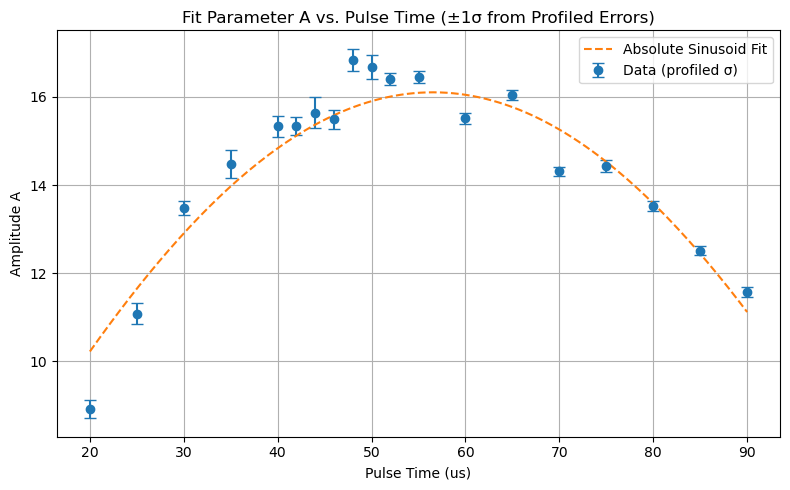

In [27]:
def abs_sinusoid(x, a, f, phi):
    return a * np.abs(np.sin(2 * np.pi * f * x + phi))

# Create a new column A_err_profiled, initially empty.
results_df['A_err_profiled'] = np.nan

# Loop over each row in results_df, which presumably matches group i = 0..N-1
# in the same order. If your results_df is sorted or built in the same order
# that you processed group_data_list, this will work directly.
for i, row in enumerate(results_df.itertuples()):
    # The profiling dictionary keys are "A_0", "A_1", etc.
    key = f"A_{i}"
    if key in profiled_errors:
        # The average ±1σ error is stored in 'A_err_est'
        A_err_est = profiled_errors[key]['A_err_est']
        # Assign this into the current row of results_df
        results_df.at[row.Index, 'A_err_profiled'] = A_err_est


# Use an initial guess, e.g., scaling from the max A, a small frequency, and zero phase.
p0_sin = [np.max(results_df['A']), 1e-3, np.pi/2]

# Now pass the profiled uncertainties 'A_err_profiled' in curve_fit.
popt_sin, pcov_sin = curve_fit(
    abs_sinusoid,
    results_df['Pulse Time (us)'],
    results_df['A'],
    sigma=results_df['A_err_profiled'],  # <-- Use the profiled errors here
    absolute_sigma=True,
    p0=p0_sin
)

# Plot A vs. Pulse Time with error bars from the *profiled* uncertainties
plt.figure(figsize=(8, 5))
plt.errorbar(results_df['Pulse Time (us)'], results_df['A'],
             yerr=results_df['A_err_profiled'],  # <-- Use the profiled errors here
             fmt='o', capsize=4, label='Data (profiled σ)')

x_fit = np.linspace(results_df['Pulse Time (us)'].min(),
                    results_df['Pulse Time (us)'].max(), 200)
y_fit = abs_sinusoid(x_fit, *popt_sin)
plt.plot(x_fit, y_fit, '--', label='Absolute Sinusoid Fit')

plt.xlabel('Pulse Time (us)')
plt.ylabel('Amplitude A')
plt.title('Fit Parameter A vs. Pulse Time (±1σ from Profiled Errors)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# Calculate the reduced chi square of the sinusoid fit
residuals = results_df['A'] - abs_sinusoid(results_df['Pulse Time (us)'], *popt_sin)
chi_square = np.sum((residuals / results_df['A_err_profiled'])**2)
dof = len(results_df) - len(popt_sin)
reduced_chi_square = chi_square / dof
print(f"Reduced Chi-square for sinusoid fit: {reduced_chi_square:.4f}")

Reduced Chi-square for sinusoid fit: 15.0980


In [29]:
# Find maximum of the absolute sinusoid fit.
def find_max_abs_sinusoid(popt, x_fit):
    a, f, phi = popt
    # Find the maximum of the absolute sinusoid.
    max_x = (np.pi/2 - phi) / (2 * np.pi * f)
    max_y = abs_sinusoid(max_x, a, f, phi)
    return max_x, max_y
max_x, max_y = find_max_abs_sinusoid(popt_sin, x_fit)
print(f"Max x (Pulse Time): {max_x:.4f} us")
print(f"Max y (Amplitude): {max_y:.4f}")

Max x (Pulse Time): 56.5376 us
Max y (Amplitude): 16.1064


# Use Hilbert transform to reconstruct envelope, then fit to decaying exponential (NOTE: doesn't work well)

In [ ]:
PAD_SIZE = 1000
def fit_decay_with_envelope(df, channel='CH1', prominence=0.2, min_distance=100):
    t = df['t'].values
    signal_raw = df[channel].values
    
    # Compute the analytic signal using the Hilbert transform
    signal_padded = np.pad(signal_raw, (PAD_SIZE, PAD_SIZE), mode="reflect")
    signal_padded = gaussian_filter1d(signal_padded, sigma=10)  # Smoothing to suppress small oscillations
    analytic_signal_padded = hilbert(signal_padded)
    analytic_signal = analytic_signal_padded[PAD_SIZE:-PAD_SIZE]  # Remove padding
    envelope = np.abs(analytic_signal)  # Extract the envelope (magnitude of analytic signal)
    envelope = gaussian_filter1d(envelope, sigma=10)  # Smoothing to suppress small oscillations
    
    # Initial guess for parameters A, T2*, and C (use the first value of the envelope as A, and its decay time)
    p0 = [envelope[0], (t.max() - t.min()) / 2.0, np.min(envelope)]
    popt, _ = curve_fit(model_exp, t, envelope, p0=p0)

    return popt, envelope

In [ ]:
results = []
fits = []

TIME_CUTOFF = 0.003  # 3 ms cutoff for the time axis

# Loop through each dataset
for idx, (df, pulse_time) in enumerate(zip(data, pulse_times)):
    df = df[df['t'] < TIME_CUTOFF]  # Apply time cutoff

    t = df['t'].values
    real_signal = df['CH1'].values
    imag_signal = df['CH2'].values

    # Subtract linear fit
    real_signal -= np.polyval(np.polyfit(t, real_signal, 1), t)
    imag_signal -= np.polyval(np.polyfit(t, imag_signal, 1), t)

    # Apply the robust envelope fitting to both real and imaginary channels
    popt_real, env_real = fit_decay_with_envelope(df, channel='CH1')
    popt_imag, env_imag = fit_decay_with_envelope(df, channel='CH2')
    
    # Store results (e.g., the T2* from the exponential fit)
    results.append({
        'Dataset': idx + 1,
        'Pulse Time (us)': pulse_time,
        'Real_T2star': popt_real[1],
        'Imag_T2star': popt_imag[1]
    })

    fits.append((t, real_signal, imag_signal, env_real, env_imag, popt_real, popt_imag))

# Display summary results
results_df = pd.DataFrame(results)
print(results_df)

# ------------------
# PLOTTING THE FITS FOR EACH DATASET
# ------------------
# Plot the results
for idx, (t, real_signal, imag_signal, env_real, env_imag, popt_real, popt_imag) in enumerate(fits):
    # Plot Real Channel (CH1)
    plt.figure(figsize=(12, 5))

    # Real part
    plt.subplot(1, 2, 1)
    plt.plot(t, real_signal, 'k.', label='Data (real)')
    plt.plot(t, env_real, 'orange', label='Envelope (real)')
    plt.plot(t, model_exp(t, *popt_real), 'b--', label='Exp Fit (real)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'Dataset {idx+1} - Real')
    plt.legend()

    # Imaginary part
    plt.subplot(1, 2, 2)
    plt.plot(t, imag_signal, 'k.', label='Data (imag)')
    plt.plot(t, env_imag, 'orange', label='Envelope (imag)')
    plt.plot(t, model_exp(t, *popt_imag), 'b--', label='Exp Fit (imag)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'Dataset {idx+1} - Imaginary')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Display summary statistics for T2* (Real and Imaginary)
def summarize(series, label):
    mean = series.mean()
    std = series.std()
    sem = std / np.sqrt(len(series))
    ci95 = 1.96 * sem
    print(f"{label}:\n  Mean T2* = {mean:.4f} us\n  Std = {std:.4f}\n  SEM = {sem:.4f}\n  95% CI = ±{ci95:.4f}\n")

# Summary for Real (CH1) and Imaginary (CH2) T2* values
real_t2star = pd.Series([popt_real[1] for _, _, _, _, _, popt_real, _ in fits])
imag_t2star = pd.Series([popt_imag[1] for _, _, _, _, _, _, popt_imag in fits])

summarize(real_t2star, "Real T2*")
summarize(imag_t2star, "Imaginary T2*")

# ------------------
# PLOTTING THE 'A' FIT PARAMETER VS. PULSE TIME
# ------------------
# Here we use the 'A' parameter from the real-part fit as the scale.
pulse_A = [popt_real[0] for (_, _, _, _, _, popt_real, _) in fits]
df_A = pd.DataFrame({'Pulse Time (us)': pulse_times, 'A': pulse_A})
grouped_A = df_A.groupby('Pulse Time (us)')['A'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(8, 6))
plt.errorbar(grouped_A['Pulse Time (us)'], grouped_A['mean'], yerr=grouped_A['std'],
             fmt='bo-', capsize=5, label="Average A (±1 STD)")
plt.xlabel('Pulse Time (us)')
plt.ylabel('Fit Parameter A')
plt.title("Fit Parameter 'A' vs. Pulse Time")
plt.legend()
plt.show()